In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
import catboost
from catboost import Pool, cv
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.special import boxcox, inv_boxcox
import missingno as msno

rcParams['figure.figsize'] = 9, 4

# Задача 1:

- Проведите аналитику полученных данных
- Подготовьте данные для регрессионной модели
- Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES
- Оцените качество модели с помощью функции metric

## Метрика для оценки Вашей модели

In [8]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

## Данные

In [9]:
df = pd.read_csv(r'data_regression_for_task.csv')
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


### Датасет содержит данные о продажах. Имеются категориальные переменные и колонки год и месяц
### Поскольку предлагается использовать только train и test, то сразу разделим датасет. Надо отделить y_test - чтобы не преобразовывать его, и "честно" считать метрику.

In [10]:
# для удобства создадим столбец с датой и посмотрим гистограмму
df['DATE'] = pd.to_datetime([f'{y}-{m}' for y, m in zip(df.YEAR, df.MONTH)])

In [11]:
df_train = df[df.DATE < '2018-02-01']
df_test = df[df.DATE == '2018-02-01']

df_train.shape,df_test.shape

((115255, 9), (13100, 9))

In [12]:
df_train.infer_objects().info() # infer_objects - for detect real types of columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115255 entries, 0 to 115255
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   YEAR           115255 non-null  int64         
 1   MONTH          115255 non-null  int64         
 2   CONTRAGENT     115234 non-null  object        
 3   ARTICLE_CODE   115255 non-null  object        
 4   ARTICLE_NAME   115255 non-null  object        
 5   ARTICLE_GROUP  115254 non-null  object        
 6   SALES          115255 non-null  float64       
 7   STORE_SALES    115255 non-null  float64       
 8   DATE           115255 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 8.8+ MB


## 1.1 Поработаем с пропусками

In [13]:
df_train.isnull().sum(),df_test.isnull().sum()

(YEAR              0
 MONTH             0
 CONTRAGENT       21
 ARTICLE_CODE      0
 ARTICLE_NAME      0
 ARTICLE_GROUP     1
 SALES             0
 STORE_SALES       0
 DATE              0
 dtype: int64,
 YEAR             0
 MONTH            0
 CONTRAGENT       3
 ARTICLE_CODE     0
 ARTICLE_NAME     0
 ARTICLE_GROUP    0
 SALES            0
 STORE_SALES      0
 DATE             0
 dtype: int64)

#### Имеются пропуски в данных. Их очень мало, в трейне можем просто удалить

In [14]:
df_train = df_train.dropna()

# в тестовой выборке будет три пропуска, заполним их самым популярным значением, не будем удалять, 
# чтобы сохранить количество прогнозируемых объектов
df_test = df_test.fillna(df.CONTRAGENT.mode().values[0])

In [15]:
# sns.pairplot(df, corner=True);

## 1.2 Предобработка численных переменных
#### Посмотрим на целевую переменную

In [16]:
df_train.groupby('DATE')['SALES'].sum()

DATE
2017-04-01            0.0
2017-05-01     94693490.0
2017-06-01     97357260.0
2017-08-01     87111780.0
2017-09-01     90452600.0
2017-10-01     89236960.0
2017-11-01     98316190.0
2017-12-01    131634490.0
2018-01-01     75791770.0
Name: SALES, dtype: float64

#### Видим, что целевая переменнуая в данных за  апрель равна нулю, т.е. не имеет данных о продажах. Апрель можно удалить

In [17]:
df_train = df_train[df_train.DATE>'2017-04-01']
df_train.groupby('DATE')['SALES'].sum()

DATE
2017-05-01     94693490.0
2017-06-01     97357260.0
2017-08-01     87111780.0
2017-09-01     90452600.0
2017-10-01     89236960.0
2017-11-01     98316190.0
2017-12-01    131634490.0
2018-01-01     75791770.0
Name: SALES, dtype: float64

#### Посмотрим основные статистические данные с помощью describe 

In [18]:
df_train.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,110038.000000,110038.000000,1.100380e+05,110038.000000
mean,2017.121249,7.829141,6.948459e+03,24.042715
std,0.326418,3.379462,3.001184e+04,248.854944
min,2017.000000,1.000000,-6.490000e+03,-4996.000000
25%,2017.000000,6.000000,0.000000e+00,0.000000
50%,2017.000000,9.000000,4.000000e+02,1.000000
75%,2017.000000,11.000000,3.700000e+03,5.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


#### В SALES и STORE_SALES среднее довольно сильно отличается от медианы. Также есть отрицательные значения. Отрицательными значения продаж быть не могут, надо обработать.

In [19]:
# Возможно просто перепутан знак. Если это возможно проверить на практике, то необходимо выяснить. 
df_train[df_train.STORE_SALES<0].STORE_SALES.value_counts().head(10)

-1.00     166
-2.00      19
-0.08      10
-3.00       9
-0.17       4
-4.00       3
-0.50       3
-0.92       2
-0.67       1
-18.00      1
Name: STORE_SALES, dtype: int64

In [20]:
df_train[df_train.SALES<0].SALES.value_counts().head(10)

-80.0      9
-170.0     9
-1000.0    4
-160.0     4
-250.0     3
-10.0      3
-90.0      2
-330.0     2
-430.0     1
-770.0     1
Name: SALES, dtype: int64

In [21]:
# количество отрицательных значений
len(df_train[df_train.STORE_SALES<0]),len(df_train[df_train.SALES<0])

(248, 49)

In [22]:
# отрицательных значений немного - заменим на нули
df_train.loc[df_train.STORE_SALES<0,'STORE_SALES']=0
df_train.loc[df_train.SALES<0,'SALES']=0
df_test.loc[df_test.STORE_SALES<0,'STORE_SALES']=0
df_test.loc[df_test.SALES<0,'SALES']=0

In [23]:
# Посмотрим корреляцию
df_train[['SALES','STORE_SALES']].corr()

,SALES,STORE_SALES
SALES,1.000000,0.468269
STORE_SALES,0.468269,1.000000


#### Посмотрим на распределение (для наглядности логарифмируем)

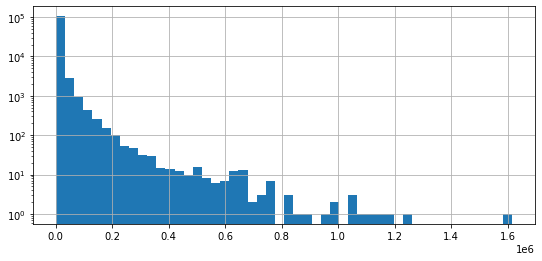

In [24]:
df_train['SALES'].hist(figsize=(9,4),log=True,bins=50);

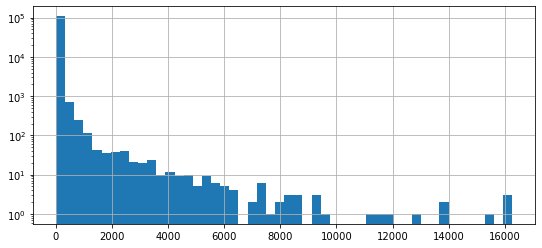

In [25]:
df_train['STORE_SALES'].hist(figsize=(9,4),log=True,bins=50);

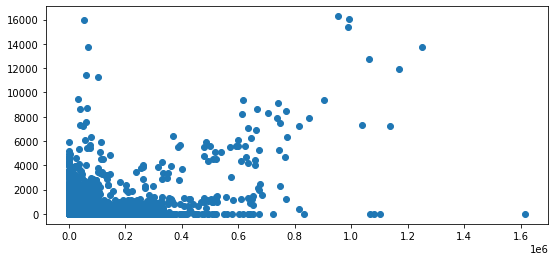

In [26]:
plt.scatter(df_train['SALES'],df_train['STORE_SALES']);

### Длинные хвосты - есть выбросы. Для их обработки используем IsolationForest

In [27]:
clf = IsolationForest( random_state = 1, max_samples=13000)

preds = clf.fit_predict(df_train[['SALES','STORE_SALES']].values)
df_train['out']=preds
out = (1-len(preds[preds==1])/len(preds))*100
print(f'Детектировали как выбросы {out:.2f} % данных для train')

preds = clf.fit_predict(df_test[['SALES','STORE_SALES']].values)
df_test['out']=preds
out = (1-len(preds[preds==1])/len(preds))*100
print(f'Детектировали как выбросы {out:.2f} % данных для test')

Детектировали как выбросы 2.96 % данных для train
Детектировали как выбросы 2.82 % данных для test


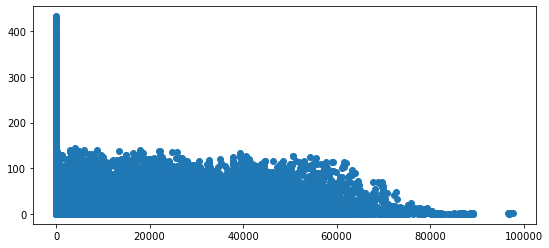

In [28]:
plt.scatter(df_train[df_train['out']==1]['SALES'],df_train[df_train['out']==1]['STORE_SALES']);

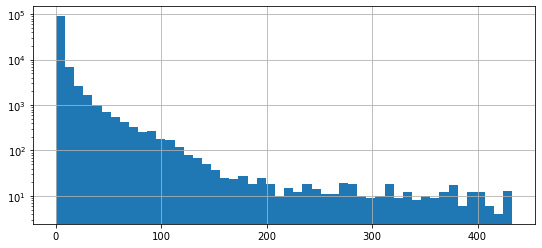

In [29]:
df_train[df_train['out']==1]['STORE_SALES'].hist(figsize=(9,4),log=True,bins=50);

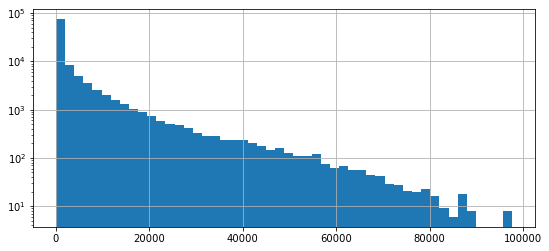

In [30]:
df_train[df_train['out']==1]['SALES'].hist(figsize=(9,4),log=True,bins=50);

### рассмотрим типы товаров

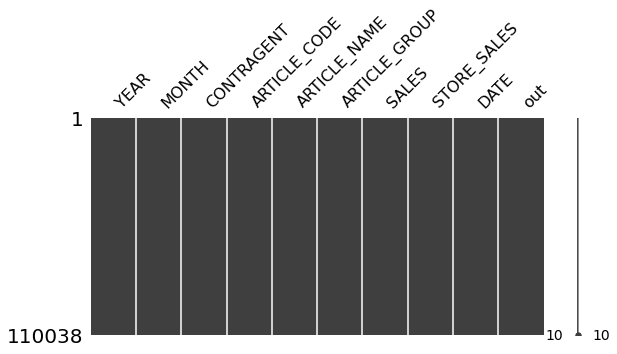

In [31]:
msno.matrix(df_train,figsize=(9,4));

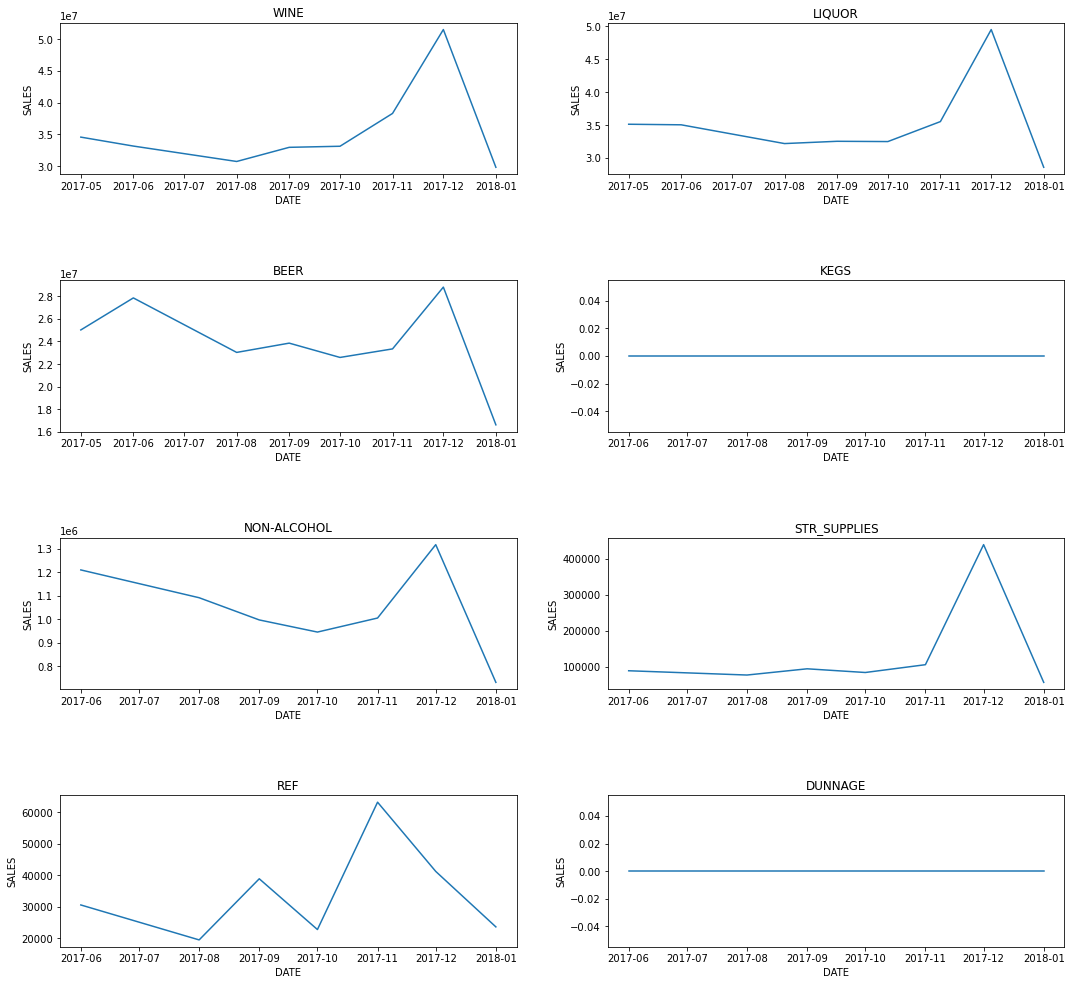

In [32]:
groups = df_train['ARTICLE_GROUP'].value_counts().index

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,17))

for i, ax in enumerate(axs.ravel()):
    data = df_train[df_train['ARTICLE_GROUP'] == groups[i]].groupby('DATE')['SALES'].sum()
    
    ax.plot(data.index.date, data, label=groups[i])
    ax.set_title(groups[i])
    ax.set_xlabel('DATE')
    ax.set_ylabel('SALES')
fig.subplots_adjust(hspace=0.7);

### KEGS & DUNNAGE - одни нули, в предсказании - тоже надо ожидать нули. Всего 8 групп товаров. Нас интересуют в основном первые три группы, безалкогольные я тоже оставлю. По остальным я занулю непрерывные переменные

In [33]:
df_train.ARTICLE_GROUP.value_counts()

WINE            68377
LIQUOR          23737
BEER            14066
KEGS             3223
NON-ALCOHOL       497
STR_SUPPLIES       86
REF                31
DUNNAGE            21
Name: ARTICLE_GROUP, dtype: int64

In [34]:
df_train.loc[(df_train.ARTICLE_GROUP == 'STR_SUPPLIES')|(df_train.ARTICLE_GROUP == 'REF'),'SALES'] = 0
df_train.loc[(df_train.ARTICLE_GROUP == 'STR_SUPPLIES')|(df_train.ARTICLE_GROUP == 'REF'),'STORE_SALES'] = 0
df_test.loc[(df_test.ARTICLE_GROUP == 'STR_SUPPLIES')|(df_test.ARTICLE_GROUP == 'REF'),'SALES'] = 0
df_test.loc[(df_test.ARTICLE_GROUP == 'STR_SUPPLIES')|(df_test.ARTICLE_GROUP == 'REF'),'STORE_SALES'] = 0

## 1.3 Предобработка категориальных переменных

In [35]:
df_train.describe(include='object')

,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP
count,110038,110038,110038,110038
unique,329,22914,22940,8
top,REPUBLIC NATIONAL DISTRIBUTING CO,65129,SANTA JULIA TORRONTES SUSTAINABLE - 750ML,WINE
freq,8556,8,16,68377


### Всего 329 контрагентов, ARTICLE_CODE и ARTICLE_NAME не всегда совпадают. Посмотрим на распределение по кат признакам

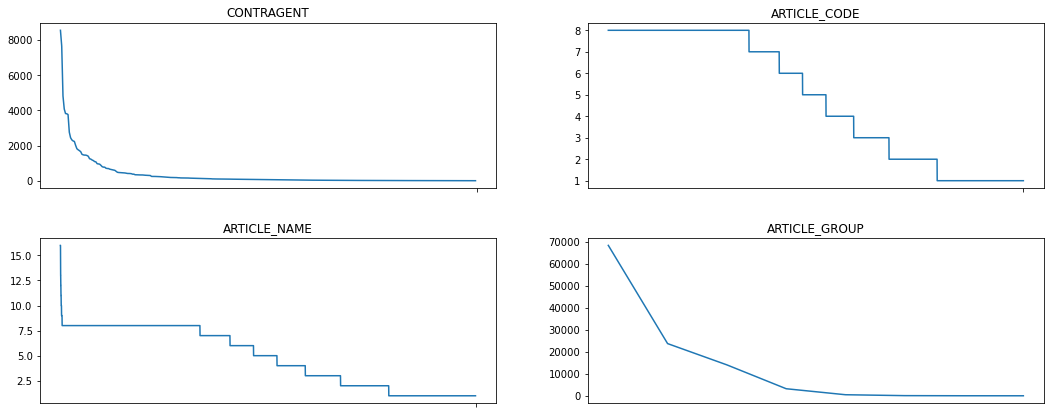

In [36]:
cat_features = ['CONTRAGENT','ARTICLE_CODE','ARTICLE_NAME','ARTICLE_GROUP']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,7))

for i, ax in enumerate(axs.ravel()):
        
    ax.plot(df_train[cat_features[i]].value_counts(), label=cat_features[i])
    ax.set_title(cat_features[i])
    ax.set_xticks('')
fig.subplots_adjust(hspace=0.3);

### В CONTRAGENT заменим все, что меньше 30 на категорию another, чтобы эти признак этих категорий мог вность хоть какой-то вклад

In [37]:
vc = df_train.CONTRAGENT.value_counts()
another_cat = vc[vc<30].index

In [38]:
df_train['CONTRAGENT'] = df_train['CONTRAGENT'].apply(lambda w: 'another' if w in another_cat else w)
df_train.CONTRAGENT.value_counts()

REPUBLIC NATIONAL DISTRIBUTING CO    8556
A VINTNERS SELECTIONS                7657
LEGENDS LTD                          4819
SOUTHERN GLAZERS WINE AND SPIRITS    4080
BACCHUS IMPORTERS LTD                3823
                                     ... 
ROBERT KACHER SELECTIONS LLC           33
KING ESTATE WINERY                     32
FRUIT OF THE VINES INC                 31
ROOTS RUN DEEP LLC                     30
JOHN GIVEN WINES INC                   30
Name: CONTRAGENT, Length: 203, dtype: int64

# Обучение модели

In [39]:
def prepare_data(data_train,data_test):
    """
    Функция для разбивки датасета на тест и трейн
    """
    
    X_train = data_train.drop(['SALES','DATE'],axis=1)
    y_train = data_train['SALES']
    X_test = data_test.drop(['SALES','DATE'],axis=1)
    y_test = data_test['SALES']
    
    return X_train, X_test, y_train, y_test

In [41]:
X_train, X_test, y_train, y_test = prepare_data(
                                        df_train[df_train['out']==1].drop(['YEAR', 'MONTH','out'],axis=1),
                                        df_test[df_test['out']==1].drop(['YEAR', 'MONTH','out'],axis=1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((106779, 5), (12730, 5), (106779,), (12730,))

In [43]:
model = catboost.CatBoostRegressor(verbose=0, n_estimators=70, random_state=42,reg_lambda=0.1,learning_rate=0.1,
                                   max_depth=9,cat_features=cat_features)

model.fit(X_train, y_train,verbose=False)
y_pred = model.predict(X_test)

df_pr_va = pd.DataFrame(y_pred,index=y_test.index,columns=['y_pred'])
df_pred = pd.concat([y_test, df_pr_va], axis=1)

metric(y_test, y_pred)

63.72837256550409

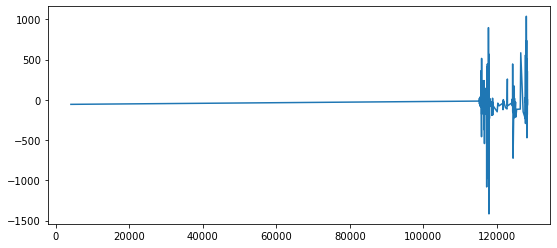

In [44]:
# если основываться только на наших данных, то для KEGS и DUNNAGE мы точно знаем, что тут будут нули, если не нули - меняем
plt.plot(df_pred.y_pred.loc[X_test[(X_test.ARTICLE_GROUP == 'KEGS')|(X_test.ARTICLE_GROUP == 'DUNNAGE')].index]);

In [45]:
df_pred.y_pred.loc[X_test[(X_test.ARTICLE_GROUP == 'KEGS')|(X_test.ARTICLE_GROUP == 'DUNNAGE')].index] = 0
df_pred.y_pred.loc[df_pred.y_pred<0] = 0
metric(y_test, df_pred.y_pred.values)

63.18604918190102

In [55]:
%%time

cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

params = {"iterations": 10000,
          "max_depth": 8,
          "loss_function": "RMSE",
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 2h 10min 12s


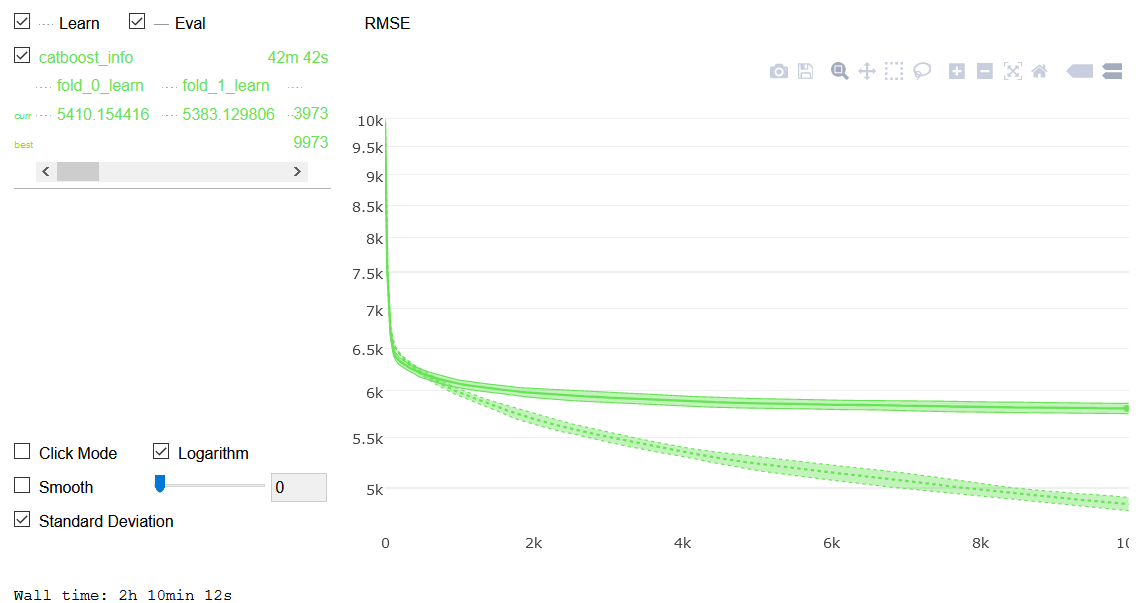

In [60]:
%%time
model = catboost.CatBoostRegressor(verbose=0, n_estimators=5000, random_state=42,reg_lambda=0.1,learning_rate=0.1,
                                   max_depth=8,cat_features=cat_features)
model.fit(X_train, y_train,verbose=False)
y_pred = model.predict(X_test)

df_pr_va = pd.DataFrame(y_pred,index=y_test.index,columns=['y_pred'])
df_pred = pd.concat([y_test, df_pr_va], axis=1)
df_pred.y_pred.loc[X_test[(X_test.ARTICLE_GROUP == 'KEGS')|(X_test.ARTICLE_GROUP == 'DUNNAGE')].index] = 0
df_pred.y_pred.loc[df_pred.y_pred<0] = 0
print('В результате работы модели получили следующую погрешность:',round(metric(y_test, df_pred.y_pred.values),6))

В результате работы модели получили следующую погрешность: 56.883114
Wall time: 9min 29s


# Задача 2:
- Проведите аналитику полученных данных
- Подготовьте данные для модели классификации
- Обучите модель классификации и осуществите прогноз для отложенной выборки с учетомо перекоса в данных TARGET
- Оцените качество модели с помощью функции f1_score

## Данные

In [3]:
df = pd.read_csv(r'data_classification_for_task.csv')
df.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Пропусков в данных нет
df.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
df.describe()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


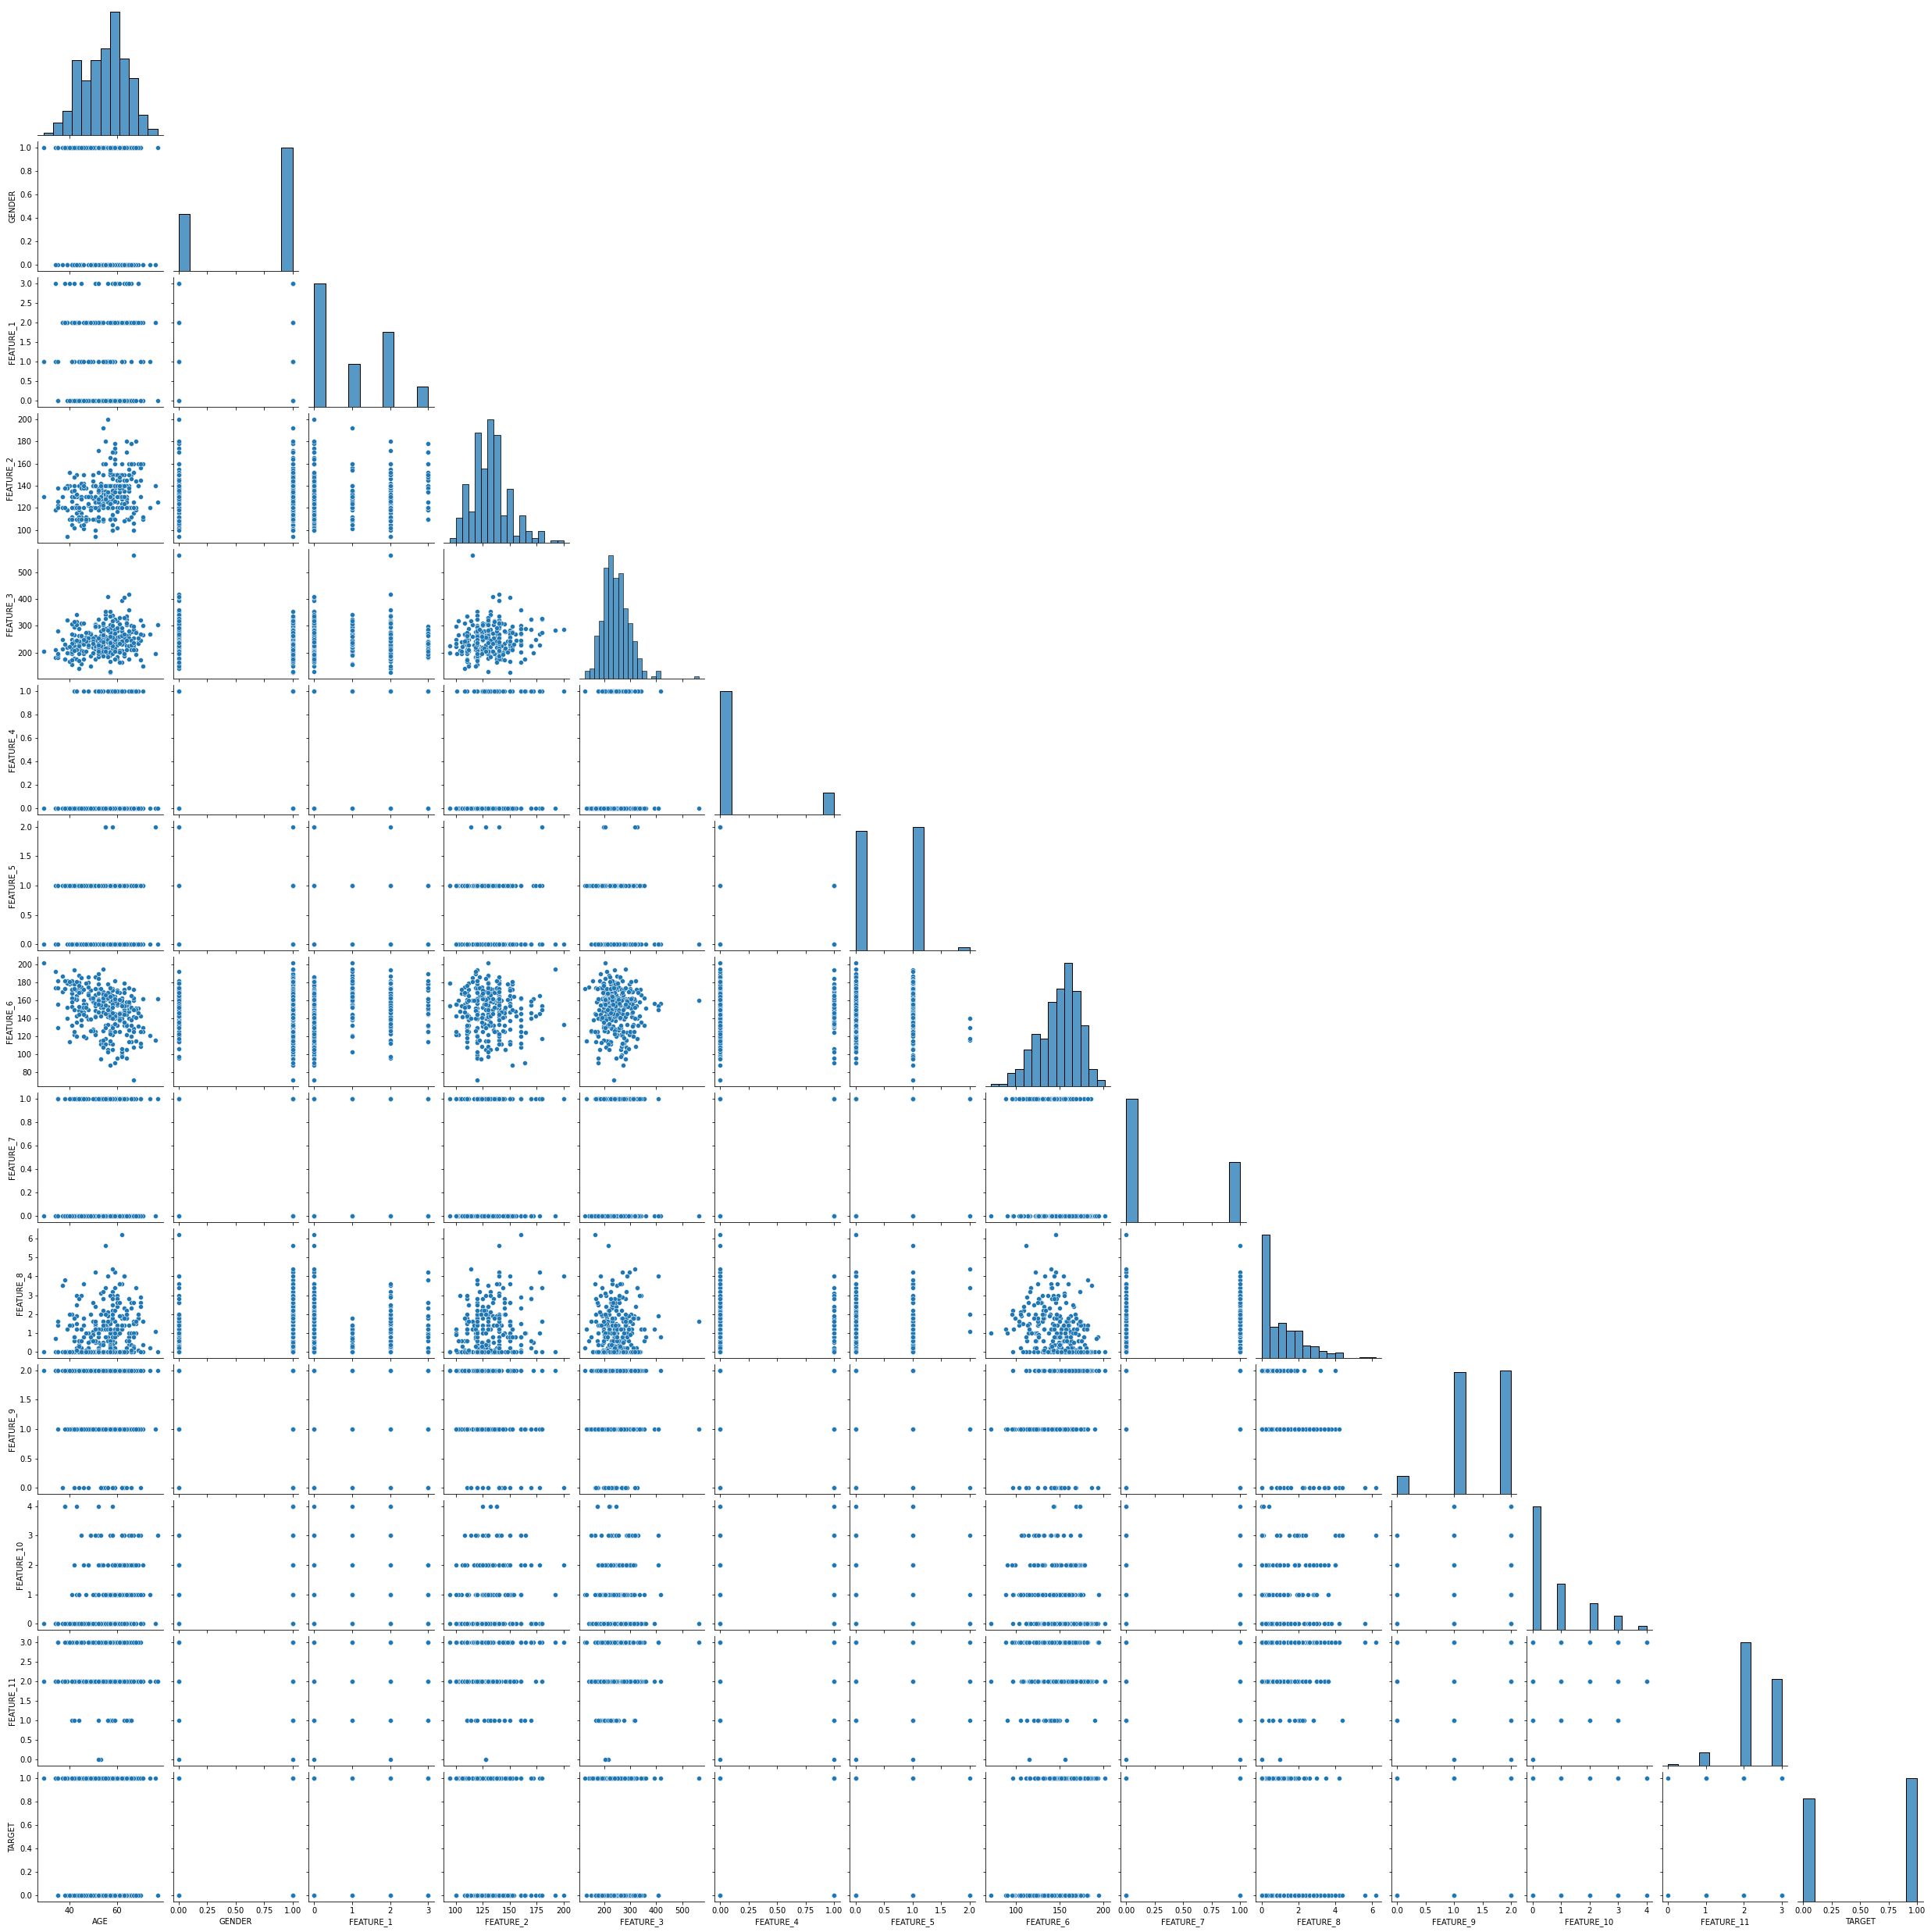

In [6]:
sns.pairplot(df, corner=True);

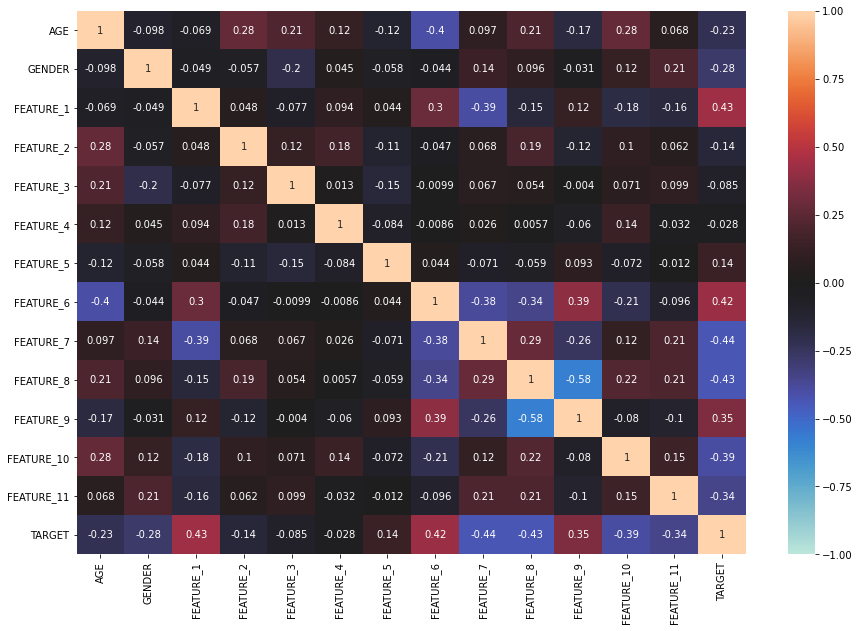

In [7]:
rcParams['figure.figsize'] = 15, 10
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0);

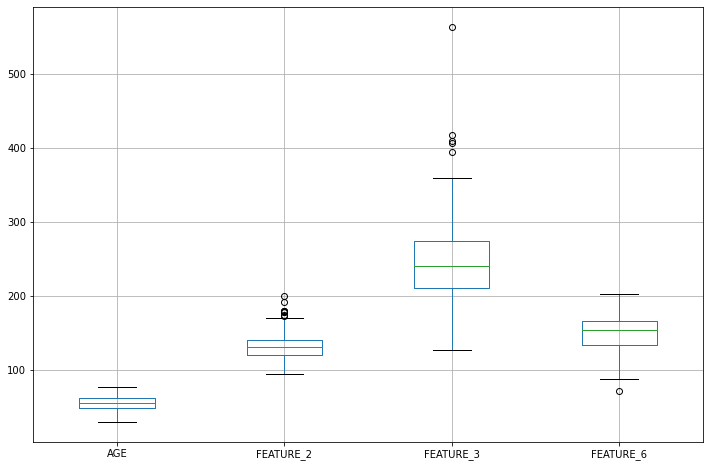

In [8]:
df[['AGE','FEATURE_2','FEATURE_3','FEATURE_6']].boxplot(figsize=(12,8));

In [9]:
df.loc[df.FEATURE_2>170,'FEATURE_2'] = df.FEATURE_2.mode()
df.loc[df.FEATURE_3>380,'FEATURE_3'] = df.FEATURE_3.mode()
df.loc[df.FEATURE_6<75,'FEATURE_6'] = df.FEATURE_6.mode()

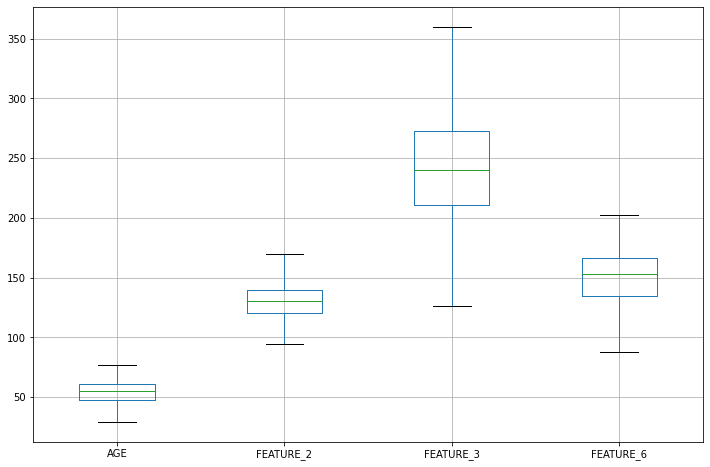

In [10]:
df[['AGE','FEATURE_2','FEATURE_3','FEATURE_6']].boxplot(figsize=(12,8));

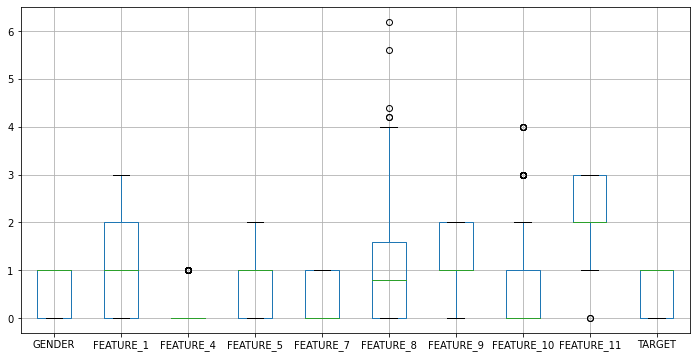

In [11]:
df.drop(['AGE','FEATURE_2','FEATURE_3','FEATURE_6'],axis=1).boxplot(figsize=(12,6));

In [12]:
df.FEATURE_5.value_counts(),df.FEATURE_9.value_counts(),df.FEATURE_10.value_counts(),df.FEATURE_11.value_counts()

(1    152
 0    147
 2      4
 Name: FEATURE_5, dtype: int64,
 2    142
 1    140
 0     21
 Name: FEATURE_9, dtype: int64,
 0    175
 1     65
 2     38
 3     20
 4      5
 Name: FEATURE_10, dtype: int64,
 2    166
 3    117
 1     18
 0      2
 Name: FEATURE_11, dtype: int64)

In [13]:
df.loc[df.FEATURE_8>4,'FEATURE_8'] = df.FEATURE_8.mode()
df.loc[df.FEATURE_10==4,'FEATURE_10'] = df.FEATURE_10.mode()
df.loc[df.FEATURE_11==0,'FEATURE_11'] = df.FEATURE_11.mode()

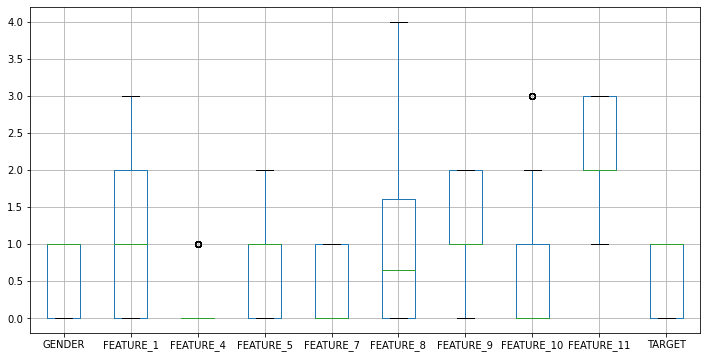

In [14]:
df.drop(['AGE','FEATURE_2','FEATURE_3','FEATURE_6'],axis=1).boxplot(figsize=(12,6));

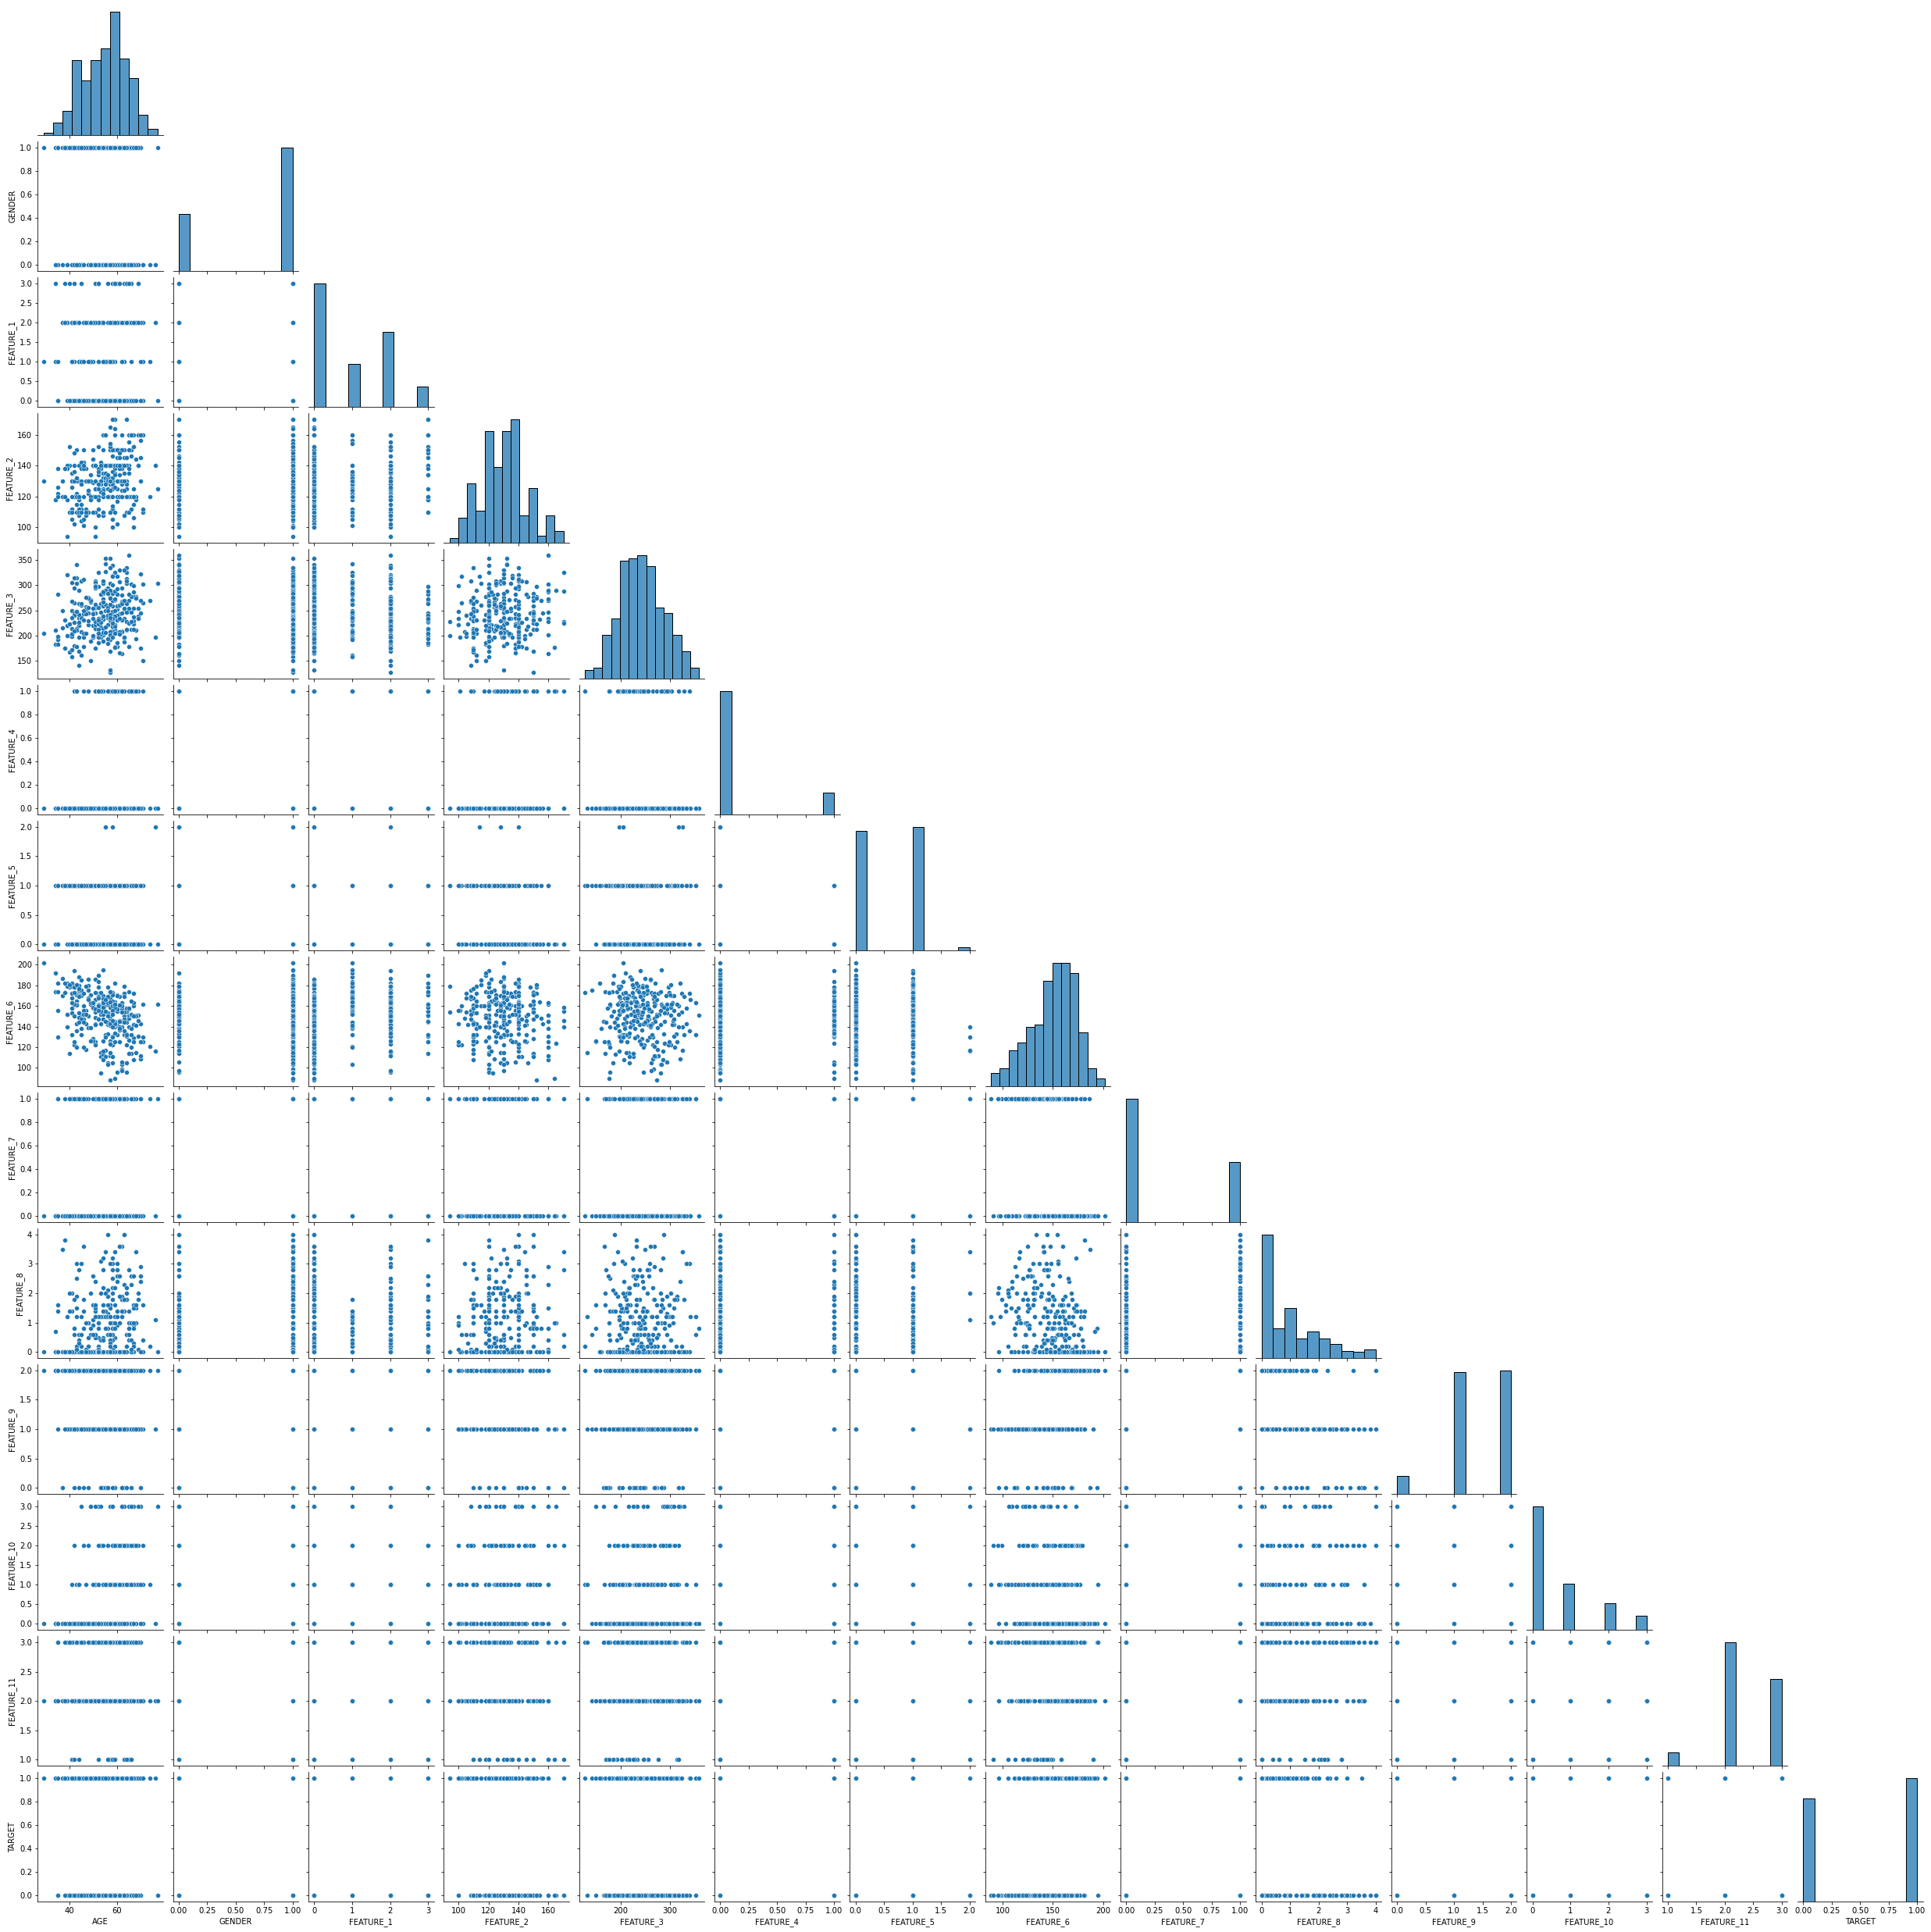

In [15]:
sns.pairplot(df, corner=True);

### Разбивка на обучающую и отложенную выборки

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('TARGET',axis=1),df['TARGET'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [30]:
cv_dataset = Pool(data=X_train,
                  label=y_train)

params = {"iterations": 500,
          "max_depth": 4,
          "loss_function": "Logloss",
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

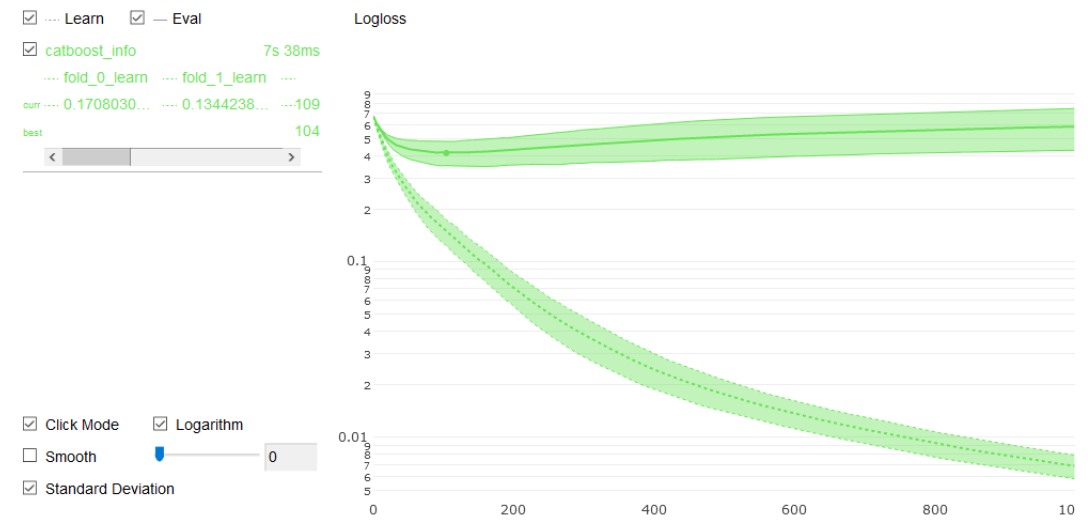

In [52]:
model = catboost.CatBoostClassifier(verbose=0, n_estimators=30, random_state=42,
                                   max_depth=2,loss_function='Logloss')
model.fit(X_train, y_train,verbose=False)
y_pred = model.predict(X_test)

df_pr_va = pd.DataFrame(y_pred,index=y_test.index,columns=['y_pred'])
df_pred = pd.concat([y_test, df_pr_va], axis=1)
print(f1_score(y_test, y_pred))

0.8923076923076922


### Выборка небольшая, очень результат сильно зависит от разбиения и выбора фолдов